## Mount to gdrive to read data, adjacency matrix, p_link and labels. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data which are processed in preprocessing_data_cancer.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/Cancer/cancer.pt"
Data = torch.load(path)
Data

{'x': tensor([[1.7990e+01, 1.0380e+01, 1.2280e+02,  ..., 2.6540e-01, 4.6010e-01,
          1.1890e-01],
         [2.0570e+01, 1.7770e+01, 1.3290e+02,  ..., 1.8600e-01, 2.7500e-01,
          8.9020e-02],
         [1.9690e+01, 2.1250e+01, 1.3000e+02,  ..., 2.4300e-01, 3.6130e-01,
          8.7580e-02],
         ...,
         [1.3030e+01, 1.8420e+01, 8.2610e+01,  ..., 5.0130e-02, 1.9870e-01,
          6.1690e-02],
         [1.3080e+01, 1.5710e+01, 8.5630e+01,  ..., 7.2830e-02, 3.1840e-01,
          8.1830e-02],
         [9.5040e+00, 1.2440e+01, 6.0340e+01,  ..., 6.2270e-02, 2.4500e-01,
          7.7730e-02]]), 'edge_index': tensor([[ 0,  0,  0,  ..., 79, 79, 79],
         [ 2,  3,  4,  ..., 72, 74, 76]]), 'y': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]), 'train

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 80
Number of features: 30
Number of classes: 2
Number of edges: 872
Average node degree: 10.90
Number of training nodes: 22
Number of testing nodes: 48
Training node label rate: 0.28


# Read p_link from gdrive to use it as the attention.

In [ ]:
path = F"/gdrive/MyDrive/Cancer/p_links_cancer.pt"
p_link = torch.load(path)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

torch.Size([80, 80])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 13.3 MB/s 
     |████████████████████████████████| 4.6 MB 8.3 MB/s 
     |████████████████████████████████| 280 kB 3.5 MB/s 


# Developing our own model (making our own message passing layers).

# BGATConv
$$ X^\prime _i = \sum_{j \in N(i)\cup i} \alpha_{ij}\Theta X_j$$
In which $\alpha$s are computed via BDgraph(p_link) and $\Theta$ is learnable parameter.

In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops

# Creating message passing network.

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes=Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x=x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

# Make GNN layers with our own model, BGAT. We use two BGAT conv.

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 30, out_channels = 15)
        self.conv2 =  BGATConv(15,2)


        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.log_softmax(h)
        return h
        
model = Myconv()
print(model)
print(model.forward(Data["x"], Data["edge_index"]))

Myconv(
  (conv1): BGATConv(30, 15)
  (conv2): BGATConv(15, 2)
)
tensor([[-5.8928e+00, -2.7629e-03],
        [-6.2349e+00, -1.9617e-03],
        [-5.5977e+00, -3.7133e-03],
        [-5.5730e+00, -3.8061e-03],
        [-3.9700e+00, -1.9054e-02],
        [-4.8565e+00, -7.8078e-03],
        [-6.3340e+00, -1.7764e-03],
        [-6.5407e+00, -1.4446e-03],
        [-5.6902e+00, -3.3845e-03],
        [-5.2904e+00, -5.0525e-03],
        [-6.6747e+00, -1.2633e-03],
        [-6.8860e+00, -1.0225e-03],
        [-4.6494e+00, -9.6129e-03],
        [-4.3784e+00, -1.2625e-02],
        [-6.3528e+00, -1.7433e-03],
        [-6.0144e+00, -2.4463e-03],
        [-5.7492e+00, -3.1905e-03],
        [-5.3906e+00, -4.5698e-03],
        [-2.9897e+00, -5.1612e-02],
        [-7.3064e+00, -6.7152e-04],
        [-7.0723e+00, -8.4865e-04],
        [-5.3999e+00, -4.5273e-03],
        [-6.2035e+00, -2.0243e-03],
        [-6.8066e+00, -1.1071e-03],
        [-6.6792e+00, -1.2576e-03],
        [-7.2586e+00, -7.0428e-04],

<ipython-input-9-3890977ceee7>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


# We take a look at the node embeddings produced by our GNN (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(z[:, 0], z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",2)).set(title = "Breast cancer dataset T-SNE projection before training (BGAT)")

<ipython-input-9-3890977ceee7>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Embedding shape: [80, 2]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


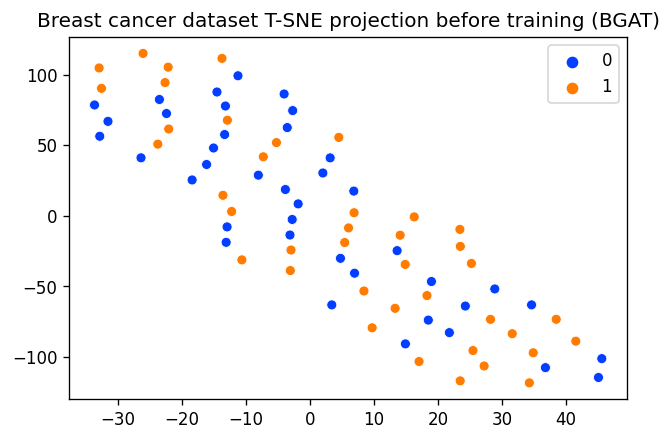

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model. 

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay = 5e-4)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out= model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out= model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        #pred = out.argmax(dim=1)
        #test_correct = pred[Data["val_mask"]] == Data["y"][Data["val_mask"]]  # Check against ground-truth labels.
        #test_acc = int(test_correct.sum()) / int(Data["val_mask"].sum())  # Derive ratio of correct predictions.
        return val_loss

In [ ]:
train_loss_ = []
val_loss_ = []

for epoch in range(1, 201):

  epoch_train_loss= []
  epoch_val_loss= []
  train_loss = train(Data)
  val_loss = val(Data)






  epoch_train_loss.append(train_loss.item())
  epoch_val_loss.append(val_loss.item())




  

  val_loss_.append(sum(epoch_val_loss)/len(epoch_val_loss))
  train_loss_.append(sum(epoch_train_loss)/len(epoch_train_loss))
  print(epoch,'Train Loss: %.3f | val Loss: %.3f'%( train_loss,val_loss))

<ipython-input-9-3890977ceee7>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


1 Train Loss: 3.015 | val Loss: 1.563
2 Train Loss: 1.955 | val Loss: 0.831
3 Train Loss: 1.004 | val Loss: 0.782
4 Train Loss: 0.650 | val Loss: 0.795
5 Train Loss: 0.660 | val Loss: 0.836
6 Train Loss: 0.701 | val Loss: 0.855
7 Train Loss: 0.699 | val Loss: 0.854
8 Train Loss: 0.747 | val Loss: 0.828
9 Train Loss: 0.736 | val Loss: 0.815
10 Train Loss: 0.705 | val Loss: 0.808
11 Train Loss: 0.697 | val Loss: 0.795
12 Train Loss: 0.686 | val Loss: 0.774
13 Train Loss: 0.664 | val Loss: 0.792
14 Train Loss: 0.648 | val Loss: 0.808
15 Train Loss: 0.641 | val Loss: 0.801
16 Train Loss: 0.639 | val Loss: 0.794
17 Train Loss: 0.637 | val Loss: 0.786
18 Train Loss: 0.640 | val Loss: 0.806
19 Train Loss: 0.640 | val Loss: 0.811
20 Train Loss: 0.636 | val Loss: 0.796
21 Train Loss: 0.624 | val Loss: 0.793
22 Train Loss: 0.620 | val Loss: 0.795
23 Train Loss: 0.620 | val Loss: 0.795
24 Train Loss: 0.619 | val Loss: 0.794
25 Train Loss: 0.616 | val Loss: 0.781
26 Train Loss: 0.607 | val Loss: 0

# Visualize train loss and val loss.

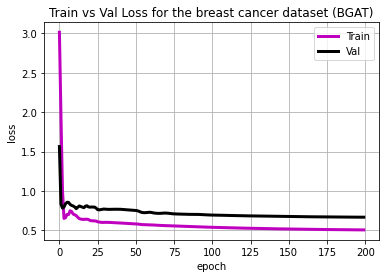

In [ ]:
plt.plot(train_loss_, "m", linewidth = 3)
plt.plot(val_loss_, "k", linewidth = 3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the breast cancer dataset (BGAT)')
plt.grid()
plt.show()

# Compute the accuracy of the model.

In [ ]:
data = pd.DataFrame([])
out = model(Data["x"], Data["edge_index"])
pred = out.argmax(dim=1) 
pred = pred[Data["test_mask"]] 
act = Data["y"][Data["test_mask"]]
df = {'y_Actual':    act,'y_Predicted':pred}
df = pd.DataFrame(df, columns=['y_Actual','y_Predicted'])
data = pd.concat((data, df), axis = 0, ignore_index = True)
#print(data, "\n")
acc = 100*(data["y_Actual"] == data["y_Predicted"]).sum()/len(data)
print(f'Accuracy:  {acc:.4f}')

Accuracy:  81.2500


<ipython-input-9-3890977ceee7>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out= model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim=1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc

In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc}')

Test Accuracy: 81.25


<ipython-input-9-3890977ceee7>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


# We take a look at the node embeddings produced by our GNN (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(z[:, 0], z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",2)).set(title = "Breast cancer dataset T-SNE projection after training (BGAT)")

<ipython-input-9-3890977ceee7>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


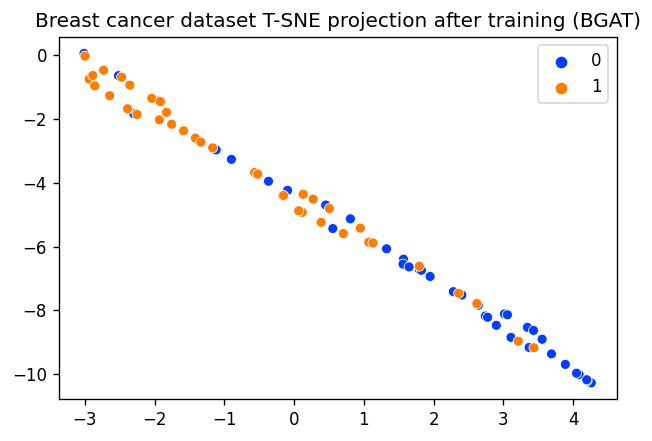

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred = out.argmax(dim=1)
pred

tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
pred = pred[Data["test_mask"]] 

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted': pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,0,0
1,0,0
2,0,0
3,0,1
4,0,0
5,0,0
6,0,1
7,0,1
8,0,0
9,0,0


<ipython-input-24-a8bd3feab9ff>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


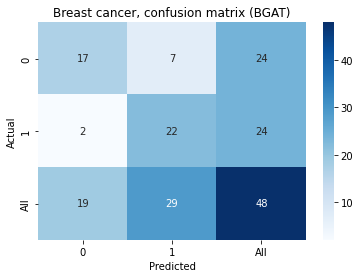

In [ ]:
confusion_matrix = pd.crosstab(data['y_Actual'], data['y_Predicted'], rownames=['Actual'], colnames = ['Predicted'], margins = True)
import seaborn as sn
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues")
ax = plt.axes()
ax.set_title('Breast cancer, confusion matrix (BGAT)')
plt.show()